In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os


#Using Fruits dataset containing 9 fruits and 40 images for each fruit

In [2]:
img_size = (224, 224)
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data Science/fruits/images",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'  # <--- use categorical for multi-class
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data Science/fruits/images",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)
class_names = train_ds.class_names
num_classes = len(class_names)

Found 360 files belonging to 9 classes.
Using 288 files for training.
Found 360 files belonging to 9 classes.
Using 72 files for validation.


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

#I will use MobileNetv2 and EfficientNet for my pre-trained Models.

#MobileNetV2

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),            # Randomly flip images horizontally
    layers.RandomRotation(0.1),                 # Randomly rotate images by 10%
    layers.RandomZoom(0.1),                     # Random zoom
    layers.RandomTranslation(0.1, 0.1),         # Randomly shift image height and width
])


#I imported MobileNetV2. The input shape was from the earlier snippet which is (224, 224, 3) I added 3 for RGB images. I did not include the original top layer of the MobileNetV2 because I will be using one for transfer learning. The weights are from imagenet and I set the base_model to false since I do not want the weights to be updated during training for feature extraction

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

In [ ]:
feature_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    data_augmentation,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
feature_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

history_feature = feature_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.6656 - loss: 1.0443 - val_accuracy: 0.8194 - val_loss: 2.2064
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.9850 - loss: 0.0716 - val_accuracy: 0.8472 - val_loss: 2.0582
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9937 - loss: 0.0239 - val_accuracy: 0.7361 - val_loss: 3.5614
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9914 - loss: 0.0585 - val_accuracy: 0.5556 - val_loss: 10.8399
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9718 - loss: 0.1468 - val_accuracy: 0.2083 - val_loss: 31.8988
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9441 - loss: 0.1672 - val_accuracy: 0.2917 - val_loss: 22.7518
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.9874 - loss: 0.0517 - val_accuracy: 0.4306 - val_loss: 14.3527
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9880 - loss: 0.0341 - val_accuracy: 0.5139 - val_loss: 13.9125
Epo

After training with frozen layers (feature extraction), i will now use fine-tuning to unfreeze the pre-trained model to allow changes in its weights. Only the last 30 layers will be unfrozen and the other layers will stay frozen.

In [ ]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
fine_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
fine_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [ ]:
history_finetune = fine_model.fit(train_ds, validation_data=val_ds, epochs=15)


Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.9782 - loss: 0.1918 - val_accuracy: 0.5278 - val_loss: 12.1697
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9859 - loss: 0.0739 - val_accuracy: 0.5139 - val_loss: 9.8829
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9947 - loss: 0.0393 - val_accuracy: 0.5278 - val_loss: 9.0126
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.9861 - loss: 0.1100 - val_accuracy: 0.5417 - val_loss: 10.1206
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9380 - loss: 0.2744 - val_accuracy: 0.7083 - val_loss: 3.1382
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9840 - loss: 0.1010 - val_accuracy: 0.6667 - val_loss: 4.0397
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9734 - loss: 0.0667 - val_accuracy: 0.6389 - val_loss: 4.5591
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.9969 - loss: 0.0132 - val_accuracy: 0.5833 - val_loss: 7.2524
Epoch 

In [ ]:
history_feature = feature_model.fit()  # for feature extraction
history_finetune = fine_model.fit()  # for fine-tuning


AttributeError: 'NoneType' object has no attribute 'shape'

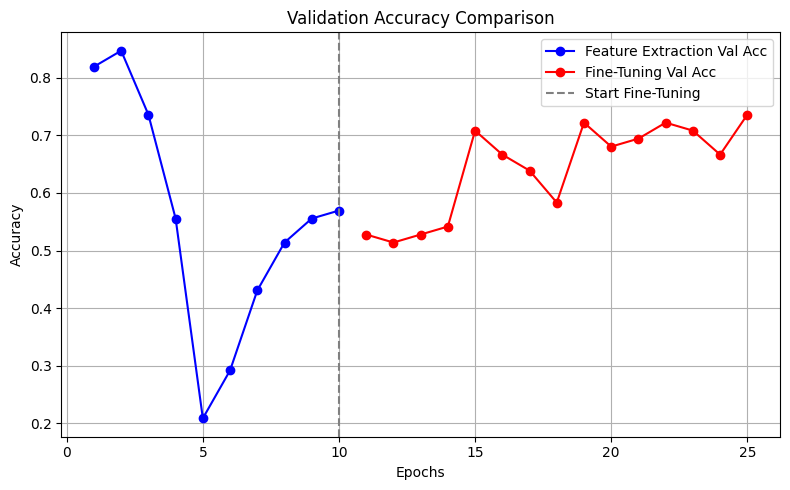

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report
def plot_history(hist1, hist2, label1='Feature Extraction', label2='Fine-Tuning'):
    acc1 = hist1.history['val_accuracy']
    acc2 = hist2.history['val_accuracy']

    epochs1 = range(1, len(acc1) + 1)
    epochs2 = range(len(acc1) + 1, len(acc1) + len(acc2) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs1, acc1, 'bo-', label=f'{label1} Val Acc')
    plt.plot(epochs2, acc2, 'ro-', label=f'{label2} Val Acc')
    plt.axvline(x=len(acc1), color='gray', linestyle='--', label='Start Fine-Tuning')

    plt.legend()
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_history(history_feature,history_finetune)


In [ ]:

y_true = np.concatenate([y for x, y in val_ds])
y_pred_feat = feature_model.predict(val_ds)
y_pred_fine = fine_model.predict(val_ds)
y_pred_feat_labels = np.argmax(y_pred_feat, axis=1)
y_pred_fine_labels = np.argmax(y_pred_fine, axis=1)
roc_feat = roc_auc_score(y_true, y_pred_feat, multi_class='ovr')
roc_fine = roc_auc_score(y_true, y_pred_fine, multi_class='ovr')
print(classification_report(y_true, y_pred_feat_labels, target_names=class_names))
print(classification_report(y_true, y_pred_fine_labels, target_names=class_names))


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
                  precision    recall  f1-score   support

     apple fruit       0.00      0.00      0.00         8
    banana fruit       0.00      0.00      0.00        11
    cherry fruit       0.22      0.20      0.21        10
   chickoo fruit       0.00      0.00      0.00         9
    grapes fruit       0.00      0.00      0.00         5
      kiwi fruit       0.09      0.38      0.15         8
     mango fruit       0.25      0.14      0.18         7
    orange fruit       0.00      0.00      0.00         4
strawberry fruit       0.22      0.20      0.21        10

        accuracy                           0.11        72
       macro avg       0.09      0.10      0.08        72
    weighted avg       0.10      0.11      0.09        72

                  precision    recall  f1-score   support

     apple fruit       0.00      0.00      0.00         8
    banana fruit       0.00      0.00      0.00      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#EfficientNet

In [4]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),            # Randomly flip images horizontally
    layers.RandomRotation(0.1),                 # Randomly rotate images by 10%
    layers.RandomZoom(0.1),                     # Random zoom
    layers.RandomTranslation(0.1, 0.1),         # Randomly shift image height and width
])

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models


base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze the base model (no training of these layers)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
feature_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    data_augmentation,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [7]:
feature_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

history_feature = feature_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 94s 8s/step - accuracy: 0.0905 - loss: 2.3224 - val_accuracy: 0.1389 - val_loss: 2.2319
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.1175 - loss: 2.2709 - val_accuracy: 0.1389 - val_loss: 2.1996
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.0893 - loss: 2.2303 - val_accuracy: 0.0556 - val_loss: 2.2281
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.0961 - loss: 2.2167 - val_accuracy: 0.1250 - val_loss: 2.1983
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.1043 - loss: 2.2086 - val_accuracy: 0.0972 - val_loss: 2.2289
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.1132 - loss: 2.2064 - val_accuracy: 0.0556 - val_loss: 2.2133
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.1049 - loss: 2.2035 - val_accuracy: 0.0694 - val_loss: 2.2153
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.0830 - loss: 2.2045 - val_accuracy: 0.1389 - val_loss: 2.1952
Epoch 9/

In [8]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [11]:
model = tf.keras.Sequential([                        # <--- Added here
    tf.keras.layers.Rescaling(1./255),
    base_model,                              # frozen MobileNetV2 base
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),# flatten feature maps
    tf.keras.layers.Dense(9, activation='softmax')  # 10 output classes (1 per fruit)
])


In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])


In [13]:
history_finetune = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 71s 5s/step - accuracy: 0.1235 - loss: 2.2019 - val_accuracy: 0.0694 - val_loss: 2.2018
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.1150 - loss: 2.2146 - val_accuracy: 0.0694 - val_loss: 2.2003
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.1226 - loss: 2.2079 - val_accuracy: 0.0694 - val_loss: 2.1993
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.1055 - loss: 2.2007 - val_accuracy: 0.0694 - val_loss: 2.1985
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.1248 - loss: 2.2154 - val_accuracy: 0.0694 - val_loss: 2.1979
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.1370 - loss: 2.2076 - val_accuracy: 0.0694 - val_loss: 2.1975
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.0948 - loss: 2.2032 - val_accuracy: 0.0694 - val_loss: 2.1973
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.1213 - loss: 2.2072 - val_accuracy: 0.0694 - val_loss: 2.1967
Epoch 9/

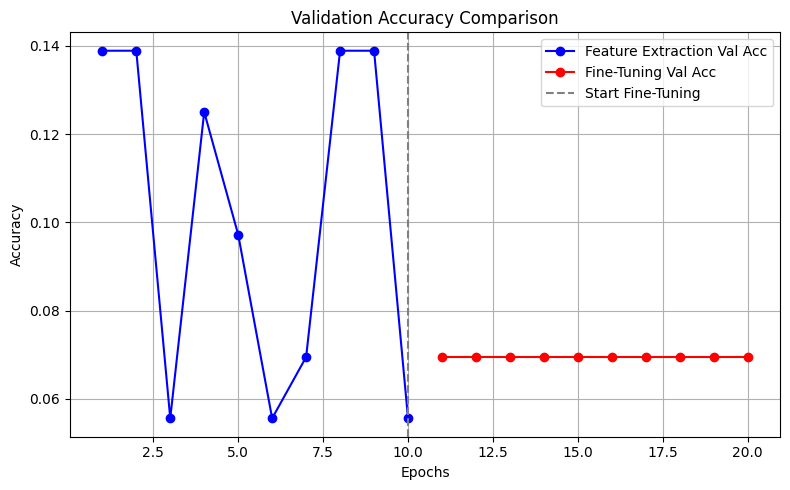

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report
def plot_history(hist1, hist2, label1='Feature Extraction', label2='Fine-Tuning'):
    acc1 = hist1.history['val_accuracy']
    acc2 = hist2.history['val_accuracy']

    epochs1 = range(1, len(acc1) + 1)
    epochs2 = range(len(acc1) + 1, len(acc1) + len(acc2) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs1, acc1, 'bo-', label=f'{label1} Val Acc')
    plt.plot(epochs2, acc2, 'ro-', label=f'{label2} Val Acc')
    plt.axvline(x=len(acc1), color='gray', linestyle='--', label='Start Fine-Tuning')

    plt.legend()
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_history(history_feature,history_finetune)


In [16]:
y_true = np.concatenate([y for x, y in val_ds])
y_pred_feat = feature_model.predict(val_ds)
y_pred_fine = model.predict(val_ds)
y_pred_feat_labels = np.argmax(y_pred_feat, axis=1)
y_pred_fine_labels = np.argmax(y_pred_fine, axis=1)
roc_feat = roc_auc_score(y_true, y_pred_feat, multi_class='ovr')
roc_fine = roc_auc_score(y_true, y_pred_fine, multi_class='ovr')
print(classification_report(y_true, y_pred_feat_labels, target_names=class_names))
print(classification_report(y_true, y_pred_fine_labels, target_names=class_names))


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step
                  precision    recall  f1-score   support

     apple fruit       0.00      0.00      0.00         8
    banana fruit       0.00      0.00      0.00        11
    cherry fruit       0.00      0.00      0.00        10
   chickoo fruit       0.00      0.00      0.00         9
    grapes fruit       0.00      0.00      0.00         5
      kiwi fruit       0.00      0.00      0.00         8
     mango fruit       0.00      0.00      0.00         7
    orange fruit       0.06      1.00      0.11         4
strawberry fruit       0.00      0.00      0.00        10

        accuracy                           0.06        72
       macro avg       0.01      0.11      0.01        72
    weighted avg       0.00      0.06      0.01        72

                  precision    recall  f1-score   support

     apple fruit       0.00      0.00      0.00         8
    banana fruit       0.00      0.00      0.00      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m